In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


from collections import Counter
from scipy.stats import mode

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
    #transforms.GaussianBlur(kernel_size=9),
])

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


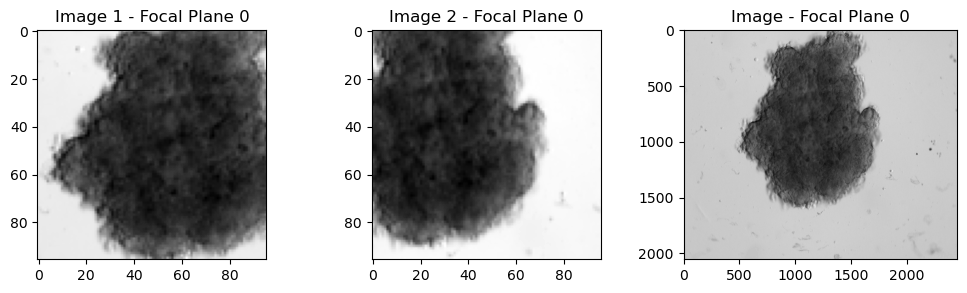

In [6]:
for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first focal plane (layer) for visualization
    layer_to_visualize = 0  # Change this to 1 or 2 if you want other layers
    
    plt.figure(figsize=(10, 3))
    
    # Normalize the 16-bit image to range [0, 1] for visualization
    image1_normalized = image1[0, layer_to_visualize].float()
    image2_normalized = image2[0, layer_to_visualize].float()
    image_normalized = image[0, layer_to_visualize].float()
    
    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1_normalized, cmap='gray')
    plt.title(f'Image 1 - Focal Plane {layer_to_visualize}')
    
    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2_normalized, cmap='gray')
    plt.title(f'Image 2 - Focal Plane {layer_to_visualize}')
    
    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image_normalized, cmap='gray')
    plt.title(f'Image - Focal Plane {layer_to_visualize}')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


In [7]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Epoch 1/100 | Train Loss: 3.0655 | Top-1 Acc: 0.10% | Top-5 Acc: 0.42% | Mean Pos: 9.13 | Val Loss: 2.6904 | Top-1 Acc: 0.17% | Top-5 Acc: 0.52% | Mean Pos: 6.27 | Time Taken: 28.49 seconds


Epoch 2/100 | Train Loss: 2.7111 | Top-1 Acc: 0.19% | Top-5 Acc: 0.51% | Mean Pos: 6.65 | Val Loss: 2.7751 | Top-1 Acc: 0.18% | Top-5 Acc: 0.51% | Mean Pos: 7.20 | Time Taken: 28.76 seconds


Epoch 3/100 | Train Loss: 2.6139 | Top-1 Acc: 0.16% | Top-5 Acc: 0.54% | Mean Pos: 6.33 | Val Loss: 2.5690 | Top-1 Acc: 0.18% | Top-5 Acc: 0.59% | Mean Pos: 5.81 | Time Taken: 27.45 seconds


Epoch 4/100 | Train Loss: 2.4980 | Top-1 Acc: 0.26% | Top-5 Acc: 0.62% | Mean Pos: 5.53 | Val Loss: 2.5821 | Top-1 Acc: 0.20% | Top-5 Acc: 0.59% | Mean Pos: 5.80 | Time Taken: 27.61 seconds


Epoch 5/100 | Train Loss: 2.3761 | Top-1 Acc: 0.25% | Top-5 Acc: 0.67% | Mean Pos: 4.98 | Val Loss: 2.6743 | Top-1 Acc: 0.20% | Top-5 Acc: 0.60% | Mean Pos: 5.88 | Time Taken: 27.56 seconds


Epoch 6/100 | Train Loss: 2.5745 | Top-1 Acc: 0.20% | Top-5 Acc: 0.61% | Mean Pos: 5.84 | Val Loss: 2.8796 | Top-1 Acc: 0.18% | Top-5 Acc: 0.53% | Mean Pos: 7.13 | Time Taken: 27.87 seconds


Epoch 7/100 | Train Loss: 2.3033 | Top-1 Acc: 0.27% | Top-5 Acc: 0.71% | Mean Pos: 4.69 | Val Loss: 2.3455 | Top-1 Acc: 0.25% | Top-5 Acc: 0.73% | Mean Pos: 4.53 | Time Taken: 28.42 seconds


Epoch 8/100 | Train Loss: 2.0415 | Top-1 Acc: 0.34% | Top-5 Acc: 0.78% | Mean Pos: 3.83 | Val Loss: 2.0696 | Top-1 Acc: 0.35% | Top-5 Acc: 0.82% | Mean Pos: 3.58 | Time Taken: 27.61 seconds


Epoch 9/100 | Train Loss: 2.0380 | Top-1 Acc: 0.35% | Top-5 Acc: 0.79% | Mean Pos: 3.78 | Val Loss: 2.0793 | Top-1 Acc: 0.34% | Top-5 Acc: 0.78% | Mean Pos: 3.80 | Time Taken: 27.52 seconds


Epoch 10/100 | Train Loss: 2.0079 | Top-1 Acc: 0.40% | Top-5 Acc: 0.82% | Mean Pos: 3.57 | Val Loss: 2.1047 | Top-1 Acc: 0.38% | Top-5 Acc: 0.81% | Mean Pos: 3.94 | Time Taken: 27.45 seconds


Epoch 11/100 | Train Loss: 2.2103 | Top-1 Acc: 0.30% | Top-5 Acc: 0.75% | Mean Pos: 4.27 | Val Loss: 2.3835 | Top-1 Acc: 0.29% | Top-5 Acc: 0.67% | Mean Pos: 4.96 | Time Taken: 27.59 seconds


Epoch 12/100 | Train Loss: 2.1513 | Top-1 Acc: 0.35% | Top-5 Acc: 0.75% | Mean Pos: 4.13 | Val Loss: 2.0299 | Top-1 Acc: 0.33% | Top-5 Acc: 0.82% | Mean Pos: 3.70 | Time Taken: 28.37 seconds


Epoch 13/100 | Train Loss: 1.8572 | Top-1 Acc: 0.38% | Top-5 Acc: 0.83% | Mean Pos: 3.30 | Val Loss: 1.8352 | Top-1 Acc: 0.40% | Top-5 Acc: 0.87% | Mean Pos: 3.02 | Time Taken: 28.06 seconds


Epoch 14/100 | Train Loss: 1.7641 | Top-1 Acc: 0.43% | Top-5 Acc: 0.83% | Mean Pos: 3.16 | Val Loss: 1.5281 | Top-1 Acc: 0.57% | Top-5 Acc: 0.91% | Mean Pos: 2.26 | Time Taken: 27.34 seconds


Epoch 15/100 | Train Loss: 1.7965 | Top-1 Acc: 0.48% | Top-5 Acc: 0.84% | Mean Pos: 3.20 | Val Loss: 2.0788 | Top-1 Acc: 0.32% | Top-5 Acc: 0.75% | Mean Pos: 4.11 | Time Taken: 28.06 seconds


Epoch 16/100 | Train Loss: 1.9817 | Top-1 Acc: 0.38% | Top-5 Acc: 0.78% | Mean Pos: 3.79 | Val Loss: 2.1384 | Top-1 Acc: 0.34% | Top-5 Acc: 0.84% | Mean Pos: 3.66 | Time Taken: 28.28 seconds


Epoch 17/100 | Train Loss: 2.1211 | Top-1 Acc: 0.33% | Top-5 Acc: 0.77% | Mean Pos: 4.11 | Val Loss: 2.1991 | Top-1 Acc: 0.38% | Top-5 Acc: 0.76% | Mean Pos: 4.25 | Time Taken: 28.32 seconds


Epoch 18/100 | Train Loss: 1.9282 | Top-1 Acc: 0.38% | Top-5 Acc: 0.80% | Mean Pos: 3.55 | Val Loss: 1.7261 | Top-1 Acc: 0.40% | Top-5 Acc: 0.88% | Mean Pos: 2.96 | Time Taken: 28.37 seconds


Epoch 19/100 | Train Loss: 1.7911 | Top-1 Acc: 0.45% | Top-5 Acc: 0.83% | Mean Pos: 3.22 | Val Loss: 1.7188 | Top-1 Acc: 0.45% | Top-5 Acc: 0.85% | Mean Pos: 2.92 | Time Taken: 27.82 seconds


Epoch 20/100 | Train Loss: 1.6297 | Top-1 Acc: 0.44% | Top-5 Acc: 0.88% | Mean Pos: 2.77 | Val Loss: 2.3245 | Top-1 Acc: 0.43% | Top-5 Acc: 0.73% | Mean Pos: 4.36 | Time Taken: 27.79 seconds


Epoch 21/100 | Train Loss: 2.1034 | Top-1 Acc: 0.32% | Top-5 Acc: 0.77% | Mean Pos: 3.77 | Val Loss: 2.3571 | Top-1 Acc: 0.31% | Top-5 Acc: 0.76% | Mean Pos: 4.34 | Time Taken: 27.52 seconds


Epoch 22/100 | Train Loss: 2.1736 | Top-1 Acc: 0.32% | Top-5 Acc: 0.73% | Mean Pos: 4.31 | Val Loss: 2.1732 | Top-1 Acc: 0.29% | Top-5 Acc: 0.77% | Mean Pos: 3.70 | Time Taken: 28.79 seconds


Epoch 23/100 | Train Loss: 2.1125 | Top-1 Acc: 0.34% | Top-5 Acc: 0.77% | Mean Pos: 3.89 | Val Loss: 1.8943 | Top-1 Acc: 0.36% | Top-5 Acc: 0.85% | Mean Pos: 3.17 | Time Taken: 28.24 seconds


Epoch 24/100 | Train Loss: 1.8171 | Top-1 Acc: 0.46% | Top-5 Acc: 0.84% | Mean Pos: 3.15 | Val Loss: 1.7861 | Top-1 Acc: 0.47% | Top-5 Acc: 0.86% | Mean Pos: 2.93 | Time Taken: 28.57 seconds


Epoch 25/100 | Train Loss: 1.7900 | Top-1 Acc: 0.43% | Top-5 Acc: 0.81% | Mean Pos: 3.27 | Val Loss: 1.6414 | Top-1 Acc: 0.52% | Top-5 Acc: 0.85% | Mean Pos: 2.75 | Time Taken: 27.54 seconds


Epoch 26/100 | Train Loss: 1.7818 | Top-1 Acc: 0.45% | Top-5 Acc: 0.82% | Mean Pos: 3.20 | Val Loss: 2.1291 | Top-1 Acc: 0.40% | Top-5 Acc: 0.75% | Mean Pos: 3.88 | Time Taken: 28.63 seconds


Epoch 27/100 | Train Loss: 1.9483 | Top-1 Acc: 0.44% | Top-5 Acc: 0.80% | Mean Pos: 3.63 | Val Loss: 2.2203 | Top-1 Acc: 0.32% | Top-5 Acc: 0.72% | Mean Pos: 4.57 | Time Taken: 28.18 seconds


Epoch 28/100 | Train Loss: 2.0038 | Top-1 Acc: 0.42% | Top-5 Acc: 0.79% | Mean Pos: 3.75 | Val Loss: 1.8913 | Top-1 Acc: 0.45% | Top-5 Acc: 0.83% | Mean Pos: 3.21 | Time Taken: 28.70 seconds


Epoch 29/100 | Train Loss: 1.7713 | Top-1 Acc: 0.44% | Top-5 Acc: 0.84% | Mean Pos: 3.18 | Val Loss: 1.7703 | Top-1 Acc: 0.43% | Top-5 Acc: 0.90% | Mean Pos: 3.05 | Time Taken: 28.04 seconds


Epoch 30/100 | Train Loss: 1.6625 | Top-1 Acc: 0.48% | Top-5 Acc: 0.87% | Mean Pos: 2.85 | Val Loss: 1.5718 | Top-1 Acc: 0.52% | Top-5 Acc: 0.92% | Mean Pos: 2.54 | Time Taken: 27.97 seconds


Epoch 31/100 | Train Loss: 1.6063 | Top-1 Acc: 0.50% | Top-5 Acc: 0.87% | Mean Pos: 2.81 | Val Loss: 1.7331 | Top-1 Acc: 0.49% | Top-5 Acc: 0.88% | Mean Pos: 2.84 | Time Taken: 28.56 seconds


Epoch 32/100 | Train Loss: 1.7830 | Top-1 Acc: 0.48% | Top-5 Acc: 0.85% | Mean Pos: 3.21 | Val Loss: 1.9285 | Top-1 Acc: 0.39% | Top-5 Acc: 0.82% | Mean Pos: 3.35 | Time Taken: 31.53 seconds


Epoch 33/100 | Train Loss: 1.8414 | Top-1 Acc: 0.40% | Top-5 Acc: 0.82% | Mean Pos: 3.40 | Val Loss: 1.9665 | Top-1 Acc: 0.36% | Top-5 Acc: 0.81% | Mean Pos: 3.94 | Time Taken: 42.32 seconds


Epoch 34/100 | Train Loss: 1.7811 | Top-1 Acc: 0.44% | Top-5 Acc: 0.83% | Mean Pos: 3.18 | Val Loss: 1.6275 | Top-1 Acc: 0.49% | Top-5 Acc: 0.86% | Mean Pos: 2.64 | Time Taken: 42.40 seconds


Epoch 35/100 | Train Loss: 1.5327 | Top-1 Acc: 0.54% | Top-5 Acc: 0.89% | Mean Pos: 2.53 | Val Loss: 1.4280 | Top-1 Acc: 0.58% | Top-5 Acc: 0.91% | Mean Pos: 2.35 | Time Taken: 42.43 seconds


Epoch 36/100 | Train Loss: 1.5107 | Top-1 Acc: 0.55% | Top-5 Acc: 0.89% | Mean Pos: 2.55 | Val Loss: 1.7352 | Top-1 Acc: 0.47% | Top-5 Acc: 0.87% | Mean Pos: 3.01 | Time Taken: 41.93 seconds


Epoch 37/100 | Train Loss: 1.8939 | Top-1 Acc: 0.43% | Top-5 Acc: 0.82% | Mean Pos: 3.32 | Val Loss: 2.2968 | Top-1 Acc: 0.36% | Top-5 Acc: 0.71% | Mean Pos: 4.49 | Time Taken: 42.65 seconds


Epoch 38/100 | Train Loss: 2.0046 | Top-1 Acc: 0.41% | Top-5 Acc: 0.80% | Mean Pos: 3.64 | Val Loss: 1.9824 | Top-1 Acc: 0.40% | Top-5 Acc: 0.78% | Mean Pos: 3.78 | Time Taken: 42.82 seconds


Epoch 39/100 | Train Loss: 1.6557 | Top-1 Acc: 0.47% | Top-5 Acc: 0.86% | Mean Pos: 2.88 | Val Loss: 1.4036 | Top-1 Acc: 0.58% | Top-5 Acc: 0.93% | Mean Pos: 2.23 | Time Taken: 42.30 seconds


Epoch 40/100 | Train Loss: 1.6534 | Top-1 Acc: 0.45% | Top-5 Acc: 0.87% | Mean Pos: 2.79 | Val Loss: 1.4032 | Top-1 Acc: 0.51% | Top-5 Acc: 0.90% | Mean Pos: 2.41 | Time Taken: 40.28 seconds


Epoch 41/100 | Train Loss: 1.4139 | Top-1 Acc: 0.57% | Top-5 Acc: 0.91% | Mean Pos: 2.32 | Val Loss: 1.7036 | Top-1 Acc: 0.52% | Top-5 Acc: 0.88% | Mean Pos: 2.64 | Time Taken: 40.72 seconds


Epoch 42/100 | Train Loss: 1.5306 | Top-1 Acc: 0.51% | Top-5 Acc: 0.89% | Mean Pos: 2.65 | Val Loss: 1.5134 | Top-1 Acc: 0.59% | Top-5 Acc: 0.92% | Mean Pos: 2.43 | Time Taken: 40.47 seconds


Epoch 43/100 | Train Loss: 1.5678 | Top-1 Acc: 0.53% | Top-5 Acc: 0.87% | Mean Pos: 2.75 | Val Loss: 2.2843 | Top-1 Acc: 0.42% | Top-5 Acc: 0.76% | Mean Pos: 3.84 | Time Taken: 41.09 seconds


Epoch 44/100 | Train Loss: 1.5531 | Top-1 Acc: 0.57% | Top-5 Acc: 0.89% | Mean Pos: 2.77 | Val Loss: 1.7569 | Top-1 Acc: 0.38% | Top-5 Acc: 0.84% | Mean Pos: 2.93 | Time Taken: 41.00 seconds


Epoch 45/100 | Train Loss: 1.5746 | Top-1 Acc: 0.52% | Top-5 Acc: 0.90% | Mean Pos: 2.65 | Val Loss: 1.7194 | Top-1 Acc: 0.51% | Top-5 Acc: 0.87% | Mean Pos: 3.06 | Time Taken: 39.82 seconds


Epoch 46/100 | Train Loss: 1.5223 | Top-1 Acc: 0.52% | Top-5 Acc: 0.89% | Mean Pos: 2.59 | Val Loss: 1.4700 | Top-1 Acc: 0.55% | Top-5 Acc: 0.92% | Mean Pos: 2.36 | Time Taken: 35.30 seconds


Epoch 47/100 | Train Loss: 1.2471 | Top-1 Acc: 0.66% | Top-5 Acc: 0.93% | Mean Pos: 2.16 | Val Loss: 1.7913 | Top-1 Acc: 0.45% | Top-5 Acc: 0.87% | Mean Pos: 2.88 | Time Taken: 27.23 seconds


Epoch 48/100 | Train Loss: 1.6158 | Top-1 Acc: 0.55% | Top-5 Acc: 0.87% | Mean Pos: 2.72 | Val Loss: 1.7803 | Top-1 Acc: 0.49% | Top-5 Acc: 0.86% | Mean Pos: 3.05 | Time Taken: 33.47 seconds


Epoch 49/100 | Train Loss: 1.7632 | Top-1 Acc: 0.47% | Top-5 Acc: 0.83% | Mean Pos: 3.20 | Val Loss: 1.8875 | Top-1 Acc: 0.40% | Top-5 Acc: 0.80% | Mean Pos: 3.33 | Time Taken: 40.33 seconds


Epoch 50/100 | Train Loss: 1.5602 | Top-1 Acc: 0.52% | Top-5 Acc: 0.89% | Mean Pos: 2.76 | Val Loss: 1.5020 | Top-1 Acc: 0.48% | Top-5 Acc: 0.91% | Mean Pos: 2.57 | Time Taken: 39.93 seconds


Epoch 51/100 | Train Loss: 1.4286 | Top-1 Acc: 0.56% | Top-5 Acc: 0.91% | Mean Pos: 2.42 | Val Loss: 1.4665 | Top-1 Acc: 0.50% | Top-5 Acc: 0.92% | Mean Pos: 2.44 | Time Taken: 40.23 seconds


Epoch 52/100 | Train Loss: 1.4873 | Top-1 Acc: 0.56% | Top-5 Acc: 0.87% | Mean Pos: 2.70 | Val Loss: 1.5439 | Top-1 Acc: 0.54% | Top-5 Acc: 0.87% | Mean Pos: 2.55 | Time Taken: 40.31 seconds


Epoch 53/100 | Train Loss: 1.5374 | Top-1 Acc: 0.49% | Top-5 Acc: 0.89% | Mean Pos: 2.62 | Val Loss: 1.6275 | Top-1 Acc: 0.45% | Top-5 Acc: 0.85% | Mean Pos: 2.87 | Time Taken: 39.30 seconds


Epoch 54/100 | Train Loss: 1.4260 | Top-1 Acc: 0.55% | Top-5 Acc: 0.91% | Mean Pos: 2.46 | Val Loss: 1.9119 | Top-1 Acc: 0.46% | Top-5 Acc: 0.84% | Mean Pos: 3.39 | Time Taken: 31.01 seconds


Epoch 55/100 | Train Loss: 1.4055 | Top-1 Acc: 0.54% | Top-5 Acc: 0.90% | Mean Pos: 2.47 | Val Loss: 1.2798 | Top-1 Acc: 0.65% | Top-5 Acc: 0.94% | Mean Pos: 2.10 | Time Taken: 26.50 seconds


Epoch 56/100 | Train Loss: 1.3342 | Top-1 Acc: 0.53% | Top-5 Acc: 0.92% | Mean Pos: 2.30 | Val Loss: 1.3278 | Top-1 Acc: 0.58% | Top-5 Acc: 0.91% | Mean Pos: 2.38 | Time Taken: 27.41 seconds


Epoch 57/100 | Train Loss: 1.2350 | Top-1 Acc: 0.62% | Top-5 Acc: 0.94% | Mean Pos: 2.08 | Val Loss: 1.8672 | Top-1 Acc: 0.46% | Top-5 Acc: 0.83% | Mean Pos: 3.48 | Time Taken: 39.18 seconds


Epoch 58/100 | Train Loss: 1.5585 | Top-1 Acc: 0.55% | Top-5 Acc: 0.88% | Mean Pos: 2.69 | Val Loss: 1.9472 | Top-1 Acc: 0.43% | Top-5 Acc: 0.83% | Mean Pos: 3.24 | Time Taken: 39.57 seconds


Epoch 59/100 | Train Loss: 1.4940 | Top-1 Acc: 0.55% | Top-5 Acc: 0.89% | Mean Pos: 2.63 | Val Loss: 1.7854 | Top-1 Acc: 0.44% | Top-5 Acc: 0.88% | Mean Pos: 3.17 | Time Taken: 39.83 seconds


Epoch 60/100 | Train Loss: 1.4004 | Top-1 Acc: 0.58% | Top-5 Acc: 0.91% | Mean Pos: 2.45 | Val Loss: 1.4893 | Top-1 Acc: 0.54% | Top-5 Acc: 0.90% | Mean Pos: 2.65 | Time Taken: 39.92 seconds


Epoch 61/100 | Train Loss: 1.1752 | Top-1 Acc: 0.68% | Top-5 Acc: 0.93% | Mean Pos: 2.00 | Val Loss: 1.4216 | Top-1 Acc: 0.54% | Top-5 Acc: 0.95% | Mean Pos: 2.33 | Time Taken: 39.54 seconds


Epoch 62/100 | Train Loss: 1.4414 | Top-1 Acc: 0.58% | Top-5 Acc: 0.90% | Mean Pos: 2.47 | Val Loss: 1.2334 | Top-1 Acc: 0.63% | Top-5 Acc: 0.94% | Mean Pos: 2.05 | Time Taken: 39.61 seconds


Epoch 63/100 | Train Loss: 1.3620 | Top-1 Acc: 0.57% | Top-5 Acc: 0.92% | Mean Pos: 2.34 | Val Loss: 1.5051 | Top-1 Acc: 0.60% | Top-5 Acc: 0.90% | Mean Pos: 2.57 | Time Taken: 27.49 seconds


Epoch 64/100 | Train Loss: 1.5983 | Top-1 Acc: 0.53% | Top-5 Acc: 0.87% | Mean Pos: 2.83 | Val Loss: 1.8595 | Top-1 Acc: 0.44% | Top-5 Acc: 0.83% | Mean Pos: 3.37 | Time Taken: 26.84 seconds


Epoch 65/100 | Train Loss: 1.4590 | Top-1 Acc: 0.59% | Top-5 Acc: 0.90% | Mean Pos: 2.54 | Val Loss: 1.7396 | Top-1 Acc: 0.49% | Top-5 Acc: 0.87% | Mean Pos: 2.81 | Time Taken: 26.83 seconds


Epoch 66/100 | Train Loss: 1.2940 | Top-1 Acc: 0.64% | Top-5 Acc: 0.91% | Mean Pos: 2.26 | Val Loss: 1.5354 | Top-1 Acc: 0.54% | Top-5 Acc: 0.89% | Mean Pos: 2.82 | Time Taken: 37.63 seconds


Epoch 67/100 | Train Loss: 1.1754 | Top-1 Acc: 0.63% | Top-5 Acc: 0.95% | Mean Pos: 2.00 | Val Loss: 1.3808 | Top-1 Acc: 0.56% | Top-5 Acc: 0.92% | Mean Pos: 2.39 | Time Taken: 40.35 seconds


Epoch 68/100 | Train Loss: 1.3855 | Top-1 Acc: 0.62% | Top-5 Acc: 0.90% | Mean Pos: 2.36 | Val Loss: 1.9421 | Top-1 Acc: 0.43% | Top-5 Acc: 0.78% | Mean Pos: 3.54 | Time Taken: 40.64 seconds


Epoch 69/100 | Train Loss: 1.5983 | Top-1 Acc: 0.50% | Top-5 Acc: 0.89% | Mean Pos: 2.68 | Val Loss: 2.2435 | Top-1 Acc: 0.39% | Top-5 Acc: 0.78% | Mean Pos: 4.27 | Time Taken: 31.15 seconds


Epoch 70/100 | Train Loss: 1.5420 | Top-1 Acc: 0.54% | Top-5 Acc: 0.88% | Mean Pos: 2.72 | Val Loss: 1.3781 | Top-1 Acc: 0.52% | Top-5 Acc: 0.96% | Mean Pos: 2.16 | Time Taken: 40.23 seconds


Epoch 71/100 | Train Loss: 1.2410 | Top-1 Acc: 0.62% | Top-5 Acc: 0.93% | Mean Pos: 2.20 | Val Loss: 1.4024 | Top-1 Acc: 0.58% | Top-5 Acc: 0.90% | Mean Pos: 2.33 | Time Taken: 41.16 seconds


Epoch 72/100 | Train Loss: 1.3128 | Top-1 Acc: 0.63% | Top-5 Acc: 0.91% | Mean Pos: 2.34 | Val Loss: 1.4215 | Top-1 Acc: 0.60% | Top-5 Acc: 0.90% | Mean Pos: 2.47 | Time Taken: 41.35 seconds


Epoch 73/100 | Train Loss: 1.2373 | Top-1 Acc: 0.63% | Top-5 Acc: 0.93% | Mean Pos: 2.17 | Val Loss: 1.5048 | Top-1 Acc: 0.55% | Top-5 Acc: 0.92% | Mean Pos: 2.58 | Time Taken: 41.32 seconds


Epoch 74/100 | Train Loss: 1.3827 | Top-1 Acc: 0.52% | Top-5 Acc: 0.92% | Mean Pos: 2.29 | Val Loss: 1.9703 | Top-1 Acc: 0.43% | Top-5 Acc: 0.81% | Mean Pos: 3.42 | Time Taken: 40.98 seconds


Epoch 75/100 | Train Loss: 1.6048 | Top-1 Acc: 0.55% | Top-5 Acc: 0.86% | Mean Pos: 2.79 | Val Loss: 1.7561 | Top-1 Acc: 0.40% | Top-5 Acc: 0.87% | Mean Pos: 2.84 | Time Taken: 39.72 seconds


Epoch 76/100 | Train Loss: 1.3924 | Top-1 Acc: 0.56% | Top-5 Acc: 0.91% | Mean Pos: 2.37 | Val Loss: 1.4636 | Top-1 Acc: 0.52% | Top-5 Acc: 0.91% | Mean Pos: 2.45 | Time Taken: 40.54 seconds


Epoch 77/100 | Train Loss: 1.4547 | Top-1 Acc: 0.54% | Top-5 Acc: 0.89% | Mean Pos: 2.55 | Val Loss: 1.3786 | Top-1 Acc: 0.56% | Top-5 Acc: 0.92% | Mean Pos: 2.23 | Time Taken: 40.20 seconds


Epoch 78/100 | Train Loss: 1.2666 | Top-1 Acc: 0.61% | Top-5 Acc: 0.93% | Mean Pos: 2.20 | Val Loss: 1.6231 | Top-1 Acc: 0.51% | Top-5 Acc: 0.90% | Mean Pos: 2.80 | Time Taken: 41.73 seconds


Epoch 79/100 | Train Loss: 1.4037 | Top-1 Acc: 0.56% | Top-5 Acc: 0.92% | Mean Pos: 2.38 | Val Loss: 1.5979 | Top-1 Acc: 0.52% | Top-5 Acc: 0.87% | Mean Pos: 2.64 | Time Taken: 39.05 seconds


Epoch 80/100 | Train Loss: 1.6091 | Top-1 Acc: 0.51% | Top-5 Acc: 0.89% | Mean Pos: 2.61 | Val Loss: 1.5786 | Top-1 Acc: 0.52% | Top-5 Acc: 0.88% | Mean Pos: 2.71 | Time Taken: 27.35 seconds


Epoch 81/100 | Train Loss: 1.1641 | Top-1 Acc: 0.64% | Top-5 Acc: 0.94% | Mean Pos: 2.00 | Val Loss: 1.3457 | Top-1 Acc: 0.64% | Top-5 Acc: 0.92% | Mean Pos: 2.20 | Time Taken: 28.29 seconds


Epoch 82/100 | Train Loss: 1.1294 | Top-1 Acc: 0.66% | Top-5 Acc: 0.94% | Mean Pos: 1.98 | Val Loss: 1.7548 | Top-1 Acc: 0.49% | Top-5 Acc: 0.87% | Mean Pos: 2.96 | Time Taken: 27.92 seconds


Epoch 83/100 | Train Loss: 1.1298 | Top-1 Acc: 0.63% | Top-5 Acc: 0.95% | Mean Pos: 1.96 | Val Loss: 1.4423 | Top-1 Acc: 0.51% | Top-5 Acc: 0.89% | Mean Pos: 2.71 | Time Taken: 27.51 seconds


Epoch 84/100 | Train Loss: 1.1280 | Top-1 Acc: 0.62% | Top-5 Acc: 0.93% | Mean Pos: 2.03 | Val Loss: 1.9092 | Top-1 Acc: 0.45% | Top-5 Acc: 0.81% | Mean Pos: 3.53 | Time Taken: 27.66 seconds


Epoch 85/100 | Train Loss: 1.3669 | Top-1 Acc: 0.58% | Top-5 Acc: 0.92% | Mean Pos: 2.44 | Val Loss: 1.9267 | Top-1 Acc: 0.47% | Top-5 Acc: 0.82% | Mean Pos: 3.47 | Time Taken: 28.01 seconds


Epoch 86/100 | Train Loss: 1.3753 | Top-1 Acc: 0.60% | Top-5 Acc: 0.94% | Mean Pos: 2.24 | Val Loss: 1.1936 | Top-1 Acc: 0.66% | Top-5 Acc: 0.96% | Mean Pos: 2.04 | Time Taken: 27.73 seconds


Epoch 87/100 | Train Loss: 1.2087 | Top-1 Acc: 0.65% | Top-5 Acc: 0.93% | Mean Pos: 2.12 | Val Loss: 1.2225 | Top-1 Acc: 0.66% | Top-5 Acc: 0.91% | Mean Pos: 2.24 | Time Taken: 26.76 seconds


Epoch 88/100 | Train Loss: 1.1288 | Top-1 Acc: 0.64% | Top-5 Acc: 0.94% | Mean Pos: 1.94 | Val Loss: 1.4939 | Top-1 Acc: 0.53% | Top-5 Acc: 0.92% | Mean Pos: 2.42 | Time Taken: 26.07 seconds


Epoch 89/100 | Train Loss: 1.0677 | Top-1 Acc: 0.70% | Top-5 Acc: 0.94% | Mean Pos: 1.95 | Val Loss: 1.6094 | Top-1 Acc: 0.52% | Top-5 Acc: 0.87% | Mean Pos: 2.75 | Time Taken: 24.96 seconds


Epoch 90/100 | Train Loss: 1.3513 | Top-1 Acc: 0.59% | Top-5 Acc: 0.92% | Mean Pos: 2.42 | Val Loss: 1.9946 | Top-1 Acc: 0.46% | Top-5 Acc: 0.80% | Mean Pos: 3.59 | Time Taken: 25.70 seconds


Epoch 91/100 | Train Loss: 1.6145 | Top-1 Acc: 0.50% | Top-5 Acc: 0.89% | Mean Pos: 2.84 | Val Loss: 1.3675 | Top-1 Acc: 0.65% | Top-5 Acc: 0.90% | Mean Pos: 2.23 | Time Taken: 33.61 seconds


Epoch 92/100 | Train Loss: 1.2204 | Top-1 Acc: 0.64% | Top-5 Acc: 0.92% | Mean Pos: 2.12 | Val Loss: 1.2907 | Top-1 Acc: 0.62% | Top-5 Acc: 0.90% | Mean Pos: 2.30 | Time Taken: 37.01 seconds


Epoch 93/100 | Train Loss: 1.1147 | Top-1 Acc: 0.68% | Top-5 Acc: 0.96% | Mean Pos: 1.82 | Val Loss: 1.2628 | Top-1 Acc: 0.61% | Top-5 Acc: 0.97% | Mean Pos: 2.08 | Time Taken: 37.66 seconds


Epoch 94/100 | Train Loss: 1.1536 | Top-1 Acc: 0.67% | Top-5 Acc: 0.93% | Mean Pos: 2.02 | Val Loss: 1.1022 | Top-1 Acc: 0.67% | Top-5 Acc: 0.97% | Mean Pos: 1.96 | Time Taken: 25.86 seconds


Epoch 95/100 | Train Loss: 1.1196 | Top-1 Acc: 0.69% | Top-5 Acc: 0.93% | Mean Pos: 2.07 | Val Loss: 1.9818 | Top-1 Acc: 0.44% | Top-5 Acc: 0.82% | Mean Pos: 3.44 | Time Taken: 25.70 seconds


Epoch 96/100 | Train Loss: 1.3329 | Top-1 Acc: 0.61% | Top-5 Acc: 0.92% | Mean Pos: 2.32 | Val Loss: 2.2489 | Top-1 Acc: 0.29% | Top-5 Acc: 0.76% | Mean Pos: 4.50 | Time Taken: 25.47 seconds


Epoch 97/100 | Train Loss: 1.1515 | Top-1 Acc: 0.66% | Top-5 Acc: 0.94% | Mean Pos: 2.07 | Val Loss: 1.4109 | Top-1 Acc: 0.58% | Top-5 Acc: 0.91% | Mean Pos: 2.37 | Time Taken: 25.44 seconds


Epoch 98/100 | Train Loss: 1.2214 | Top-1 Acc: 0.63% | Top-5 Acc: 0.94% | Mean Pos: 2.12 | Val Loss: 0.9753 | Top-1 Acc: 0.72% | Top-5 Acc: 0.97% | Mean Pos: 1.63 | Time Taken: 25.85 seconds


Epoch 99/100 | Train Loss: 0.9446 | Top-1 Acc: 0.73% | Top-5 Acc: 0.96% | Mean Pos: 1.66 | Val Loss: 1.2704 | Top-1 Acc: 0.64% | Top-5 Acc: 0.95% | Mean Pos: 2.12 | Time Taken: 25.79 seconds


Epoch 100/100 | Train Loss: 1.0550 | Top-1 Acc: 0.68% | Top-5 Acc: 0.95% | Mean Pos: 1.90 | Val Loss: 1.5522 | Top-1 Acc: 0.62% | Top-5 Acc: 0.90% | Mean Pos: 2.50 | Time Taken: 25.95 seconds
Total Training Time: 3283.43 seconds


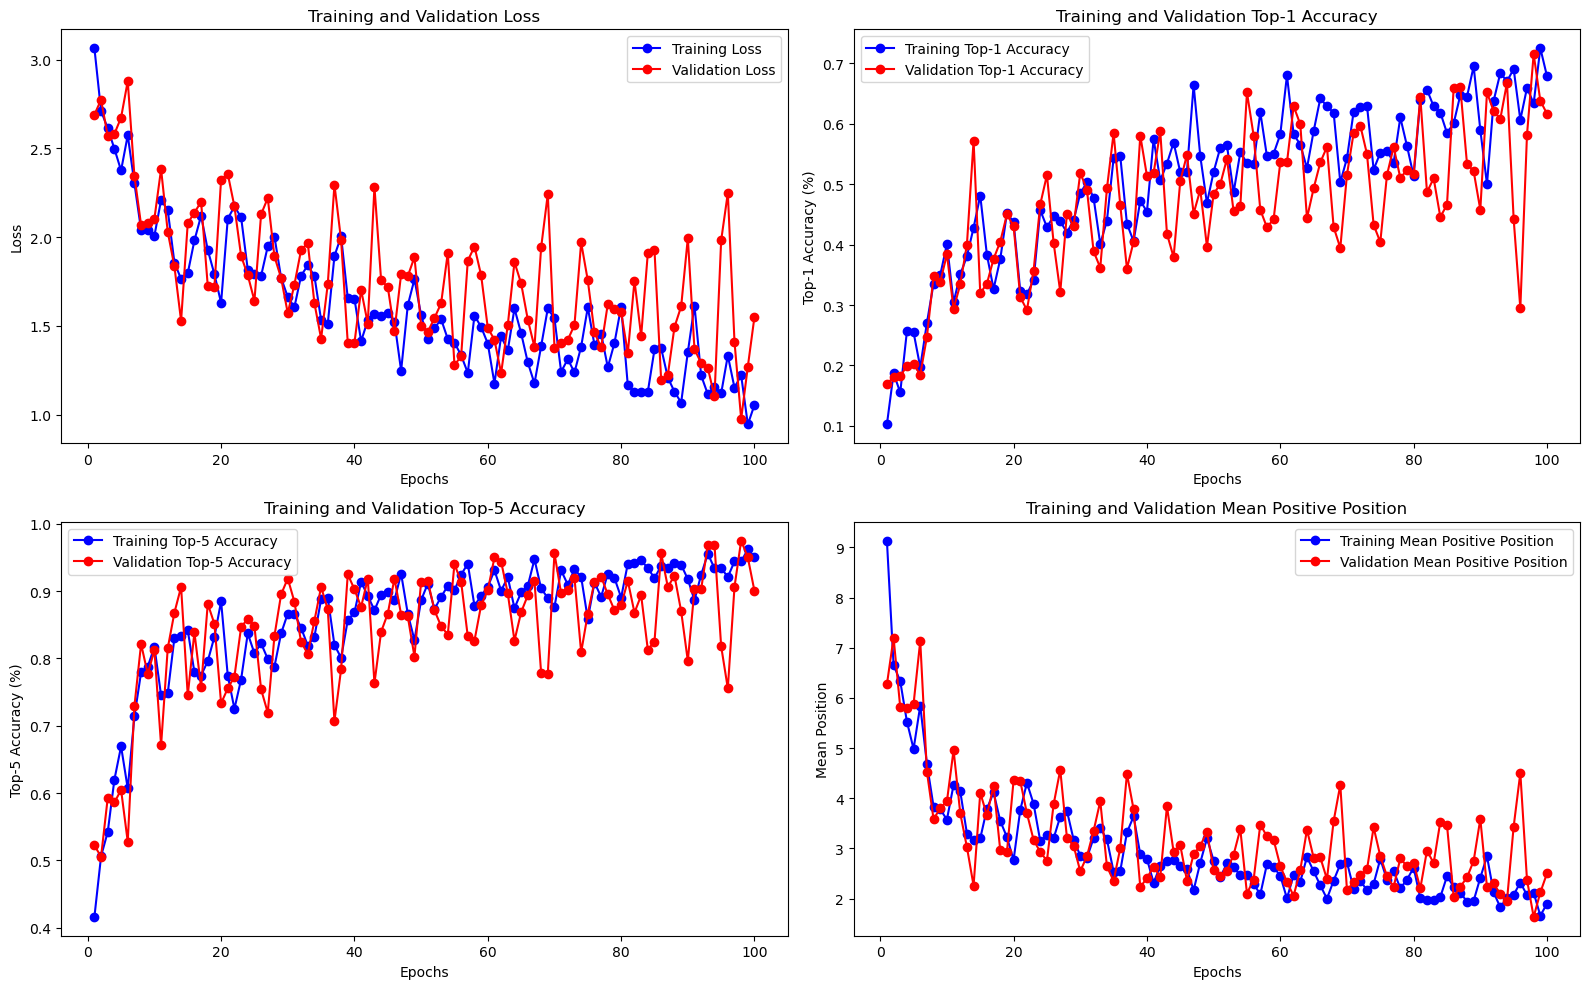

In [10]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=100)

In [8]:
#torch.save(simclr_model.state_dict(), 'model_weights.pth')
full_model_path =  r'C:\Users\k54739\saved_model\simclr_model.pth' 
#torch.save(simclr_model, full_model_path)



In [9]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [10]:
simclr_model = torch.load(full_model_path)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_4352\181344158.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [11]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_data(root_dir):
    classes = ['untreated', 'single_dose']   #classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'untreated': 30, 'single_dose': 30}


In [12]:
for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1])


In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [14]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:01<00:03,  1.12s/it]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.05it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.11it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

Batch features shape: torch.Size([12, 20])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([60, 20])
Labels shape after concatenation: torch.Size([60])


In [15]:
# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (60, 512)
labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (60, 20)
Shape of labels: (60,)


From scratch

In [16]:

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

# Function to run K-Means algorithm with cost tracking
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    
    best_centroids = centroids
    lowest_cost = float('inf')
    final_iteration = 0  # To keep track of the iteration where the best centroids were found
    best_idx = idx

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function for the current centroids
        cost = np.sum(np.linalg.norm(X - centroids[idx], axis=1)**2)
        print(f"Cost function value: {cost:.4f}")  # Print the cost function value

        # Check if this is the best cost so far
        if cost < lowest_cost:
            lowest_cost = cost
            best_centroids = centroids
            best_idx = idx.copy()
            final_iteration = i  # Update the iteration where best centroids were found

    print(f"Final centroids selected from iteration: {final_iteration}")  # Indicate which iteration was chosen
    return best_centroids, best_idx, centroids,idx  # Return the best centroids



In [19]:
K = 2                          # Step 2: Set number of clusters
initial_centroids = kMeans_init_centroids(feats_np, K)  # Step 3: Initialize centroids 
max_iters = 100                # Step 4: Number of iterations

best_centroids, best_idx, centroids, idx = run_kMeans(feats_np, initial_centroids, max_iters)  # Step 5: Run K-Means
print("Final centroids:", best_centroids)  # Output the final centroids

K-Means iteration 0/99
Cost function value: 10034.6361
K-Means iteration 1/99
Cost function value: 10034.6361
K-Means iteration 2/99
Cost function value: 10034.6361
K-Means iteration 3/99
Cost function value: 10034.6361
K-Means iteration 4/99
Cost function value: 10034.6361
K-Means iteration 5/99
Cost function value: 10034.6361
K-Means iteration 6/99
Cost function value: 10034.6361
K-Means iteration 7/99
Cost function value: 10034.6361
K-Means iteration 8/99
Cost function value: 10034.6361
K-Means iteration 9/99
Cost function value: 10034.6361
K-Means iteration 10/99
Cost function value: 10034.6361
K-Means iteration 11/99
Cost function value: 10034.6361
K-Means iteration 12/99
Cost function value: 10034.6361
K-Means iteration 13/99
Cost function value: 10034.6361
K-Means iteration 14/99
Cost function value: 10034.6361
K-Means iteration 15/99
Cost function value: 10034.6361
K-Means iteration 16/99
Cost function value: 10034.6361
K-Means iteration 17/99
Cost function value: 10034.6361
K-

In [20]:
print("Cluster assignments:", idx)
print("True labels:", labels_np)

Cluster assignments: [1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1]
True labels: [1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1]


In [21]:
print("Cluster assignments:", best_idx)
print("True labels:", labels_np)

Cluster assignments: [1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1]
True labels: [1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1]


In [22]:
from collections import Counter
import numpy as np

# Assuming `idx` contains the cluster assignments from KMeans
# and `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")


Cluster 0 has true labels: Counter({0: 30})
Cluster 1 has true labels: Counter({1: 30})


In [23]:
K = len(np.unique(best_idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(best_idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({0: 30})
Cluster 1 has true labels: Counter({1: 30})


In [24]:
from scipy.stats import mode
import numpy as np

# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels




In [25]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [26]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, best_idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [28]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


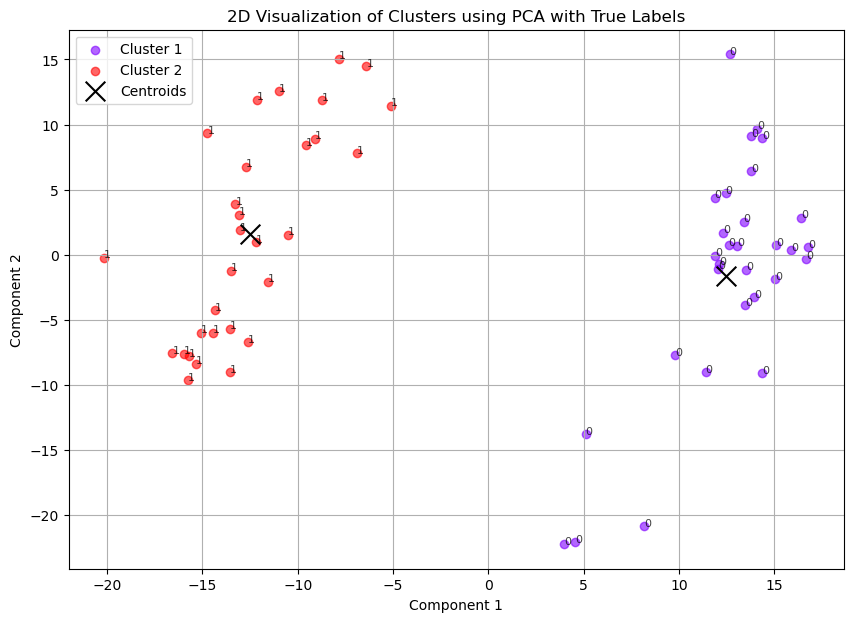

In [29]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)


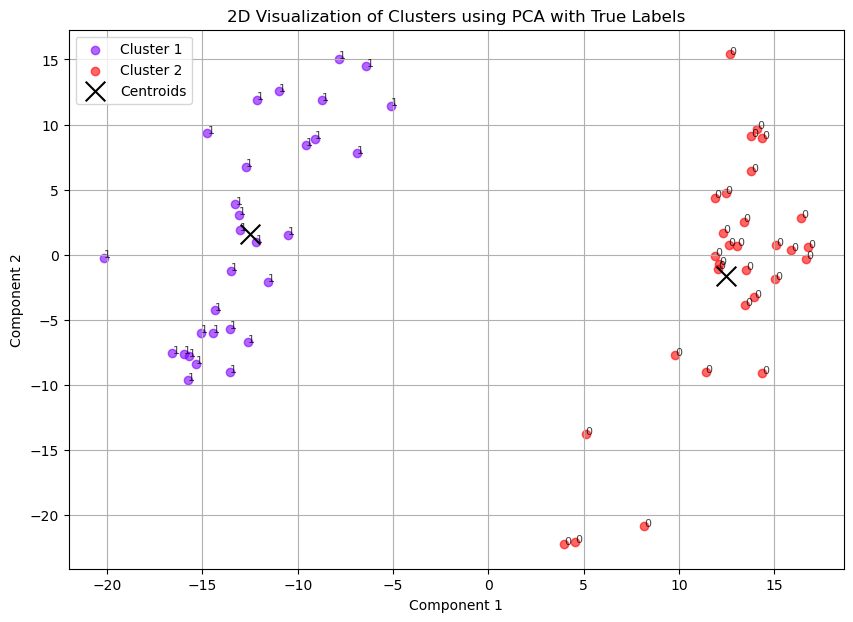

In [24]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np, best_centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, best_idx, labels_np, K)
